# international_migration/Unemployemnt

This note works with international migration with unemployment  

Meta Migration Data: https://data.humdata.org/dataset/international-migration-flows)    

NUTS Unemployment 
Unemployment by sex, age, citizenship and NUTS 2 region: estat_lfst_r_lfu2gan  https://ec.europa.eu/eurostat/databrowser/explore/all/all_themes?lang=en&display=list&sort=category  
Unemployment Rate: estat_lfst_r_lfur2gan   

International Unemployment: ILO https://data.worldbank.org/indicator/SL.UEM.TOTL.ZS  

Special countries: BA, UA, XK, UK/GB, EL/GR 

In [1]:
import os
import gc
import rasterio
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import geopandas as gpd
from pathlib import Path
from osgeo import gdal, osr
import dask_geopandas as dgpd
import matplotlib.pyplot as plt
from rasterstats import zonal_stats
from scipy.stats import linregress

BASE_DIR = Path('/Users/wenlanzhang/PycharmProjects/Mapineq/src/data-wrangling/')
DATA_DIR = Path('/Users/wenlanzhang/Downloads/PhD_UCL/Data/Oxford')

# Load & Clean Migration Data (International + NUTS)

In [4]:
# Step 1: Load international migration data
def load_international_migration(filepath):
    df = pd.read_csv(filepath)
    df['year'] = pd.to_datetime(df['migration_month']).dt.year
    df['month'] = pd.to_datetime(df['migration_month']).dt.month

    # Country code mapping
    country_code_mapping = {'GR': 'EL', 'GB': 'UK'}
    df['country_from'] = df['country_from'].replace(country_code_mapping)
    df['country_to'] = df['country_to'].replace(country_code_mapping)
    
    return df

migration_df = load_international_migration(DATA_DIR / "Migration/international_migration_flow.csv")
migration_df

,country_from,country_to,migration_month,num_migrants,year,month
0,AD,AE,2019-01,12,2019,1
1,AD,AE,2019-02,2,2019,2
2,AD,AE,2019-03,1,2019,3
3,AD,AE,2019-04,7,2019,4
4,AD,AE,2019-05,0,2019,5
...,...,...,...,...,...,...
1563149,ZW,ZM,2022-08,138,2022,8
1563150,ZW,ZM,2022-09,162,2022,9
1563151,ZW,ZM,2022-10,149,2022,10
1563152,ZW,ZM,2022-11,104,2022,11


In [5]:
# Step 2: Compute inflow and outflow
def compute_inflow_outflow(df):
    outflow = df.groupby(['country_from', 'year'])['num_migrants'].sum().reset_index()
    inflow = df.groupby(['country_to', 'year'])['num_migrants'].sum().reset_index()

    outflow = outflow.rename(columns={'country_from': 'geo', 'num_migrants': 'outflow'})
    inflow = inflow.rename(columns={'country_to': 'geo', 'num_migrants': 'inflow'})

    return pd.merge(outflow, inflow, on=['geo', 'year'], how='outer').fillna(0)

migration_flow = compute_inflow_outflow(migration_df)
migration_flow

,geo,year,outflow,inflow
0,AD,2019,7301,8390
1,AD,2020,7414,7908
2,AD,2021,7446,6923
3,AD,2022,7142,9685
4,AE,2019,769808,1248145
...,...,...,...,...
715,ZM,2022,27844,27207
716,ZW,2019,71874,39165
717,ZW,2020,53204,38031
718,ZW,2021,51055,43564


# Eurostat

36 countries, missing: 
- AL: Albania
- LI: Liechtenstein
- UA:Ukraine
- XK: Kosovo

## Unemployment Data

In [6]:
# Step 3: Load and prepare employment data
def load_employment_data(filepath):
    raw = pd.read_csv(filepath, delimiter='\t', dtype=str)

    id_cols = ['freq', 'citizen', 'age', 'sex', 'unit', 'geo']
    raw[id_cols] = raw.iloc[:, 0].str.split(',', expand=True)
    raw = raw.drop(columns=raw.columns[0])

    tidy = raw.melt(id_vars=id_cols, var_name='year', value_name='value')
    tidy[['numeric_value', 'flag']] = tidy['value'].str.extract(r'([\d.]+|:)\s*([a-z]*)')
    tidy['numeric_value'] = tidy['numeric_value'].replace(':', np.nan).astype(float)
    tidy['year'] = tidy['year'].astype(int)

    return tidy[
        (tidy['citizen'] == 'TOTAL') &
        (tidy['sex'] == 'T') &
        (tidy['age'] == 'Y20-64') &
        (tidy['geo'].str.match(r'^[A-Za-z]{2}$')) &
        (tidy['year'].between(2019, 2022)) &
        (tidy['geo'] != '')
    ][['geo', 'year', 'numeric_value']]

employment_data_NUTS = load_employment_data(DATA_DIR / "Migration/unemployment/estat_lfst_r_lfu2gan.tsv")
employment_data_NUTS

,geo,year,numeric_value
998389,AT,2019,187.9
998402,BA,2019,NaN
998403,BE,2019,260.2
998418,BG,2019,126.0
998427,CH,2019,193.6
...,...,...,...
1141919,SE,2022,326.7
1141931,SI,2022,38.3
1141937,SK,2022,162.1
1141943,TR,2022,3302.8


### NUTS Merge and Plot

In [7]:
# Step 4: Merge migration and employment
def merge_migration_employment_NUTS(migration_df, employment_df):
    return pd.merge(
        migration_df, employment_df,
        on=['geo', 'year'],
        how='inner'
    ).rename(columns={'numeric_value': 'unemployment'})

merged_NUTS_df = merge_migration_employment_NUTS(migration_flow, employment_data_NUTS)
merged_NUTS_df

,geo,year,outflow,inflow,unemployment
0,AT,2019,75894,103587,187.9
1,AT,2020,78738,76056,227.2
2,AT,2021,66872,82422,260.8
3,AT,2022,61468,154988,200.4
4,BA,2019,60246,26869,NaN
...,...,...,...,...,...
139,TR,2022,521337,359872,3302.8
140,UK,2019,670647,856989,1056.8
141,UK,2020,629902,658333,NaN
142,UK,2021,470148,845371,NaN


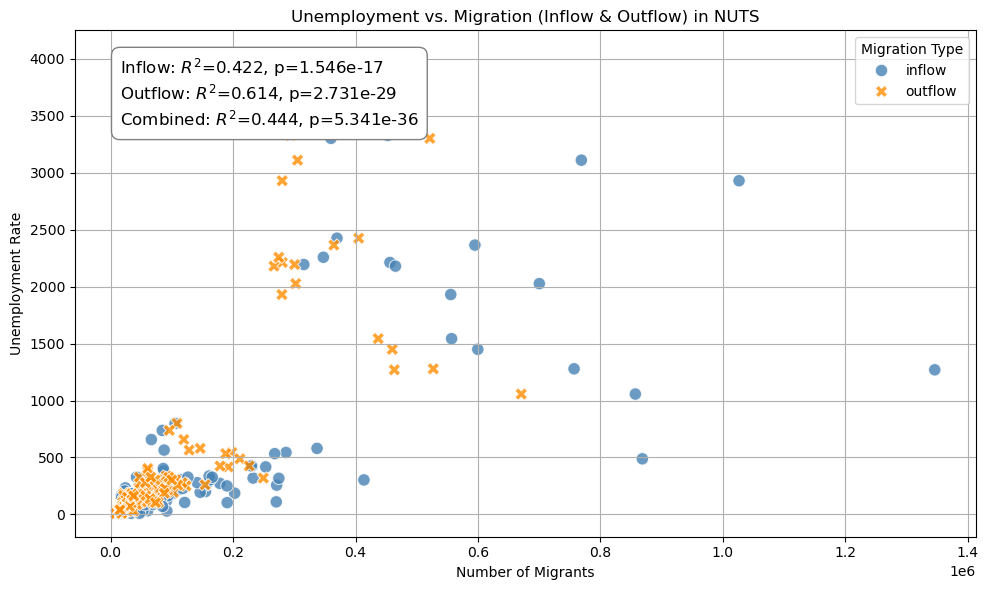

In [17]:
# def plot_nuts_migration_vs_unemployment(merged_NUTS_df):
#     """Scatterplot inflow and outflow vs unemployment rate for NUTS regions with R² and p-values."""
#     plot_data = merged_NUTS_df.dropna(subset=['unemployment', 'inflow', 'outflow'])

#     plot_long = pd.melt(
#         plot_data,
#         id_vars=['geo', 'year', 'unemployment'],
#         value_vars=['inflow', 'outflow'],
#         var_name='flow_type',
#         value_name='num_migrants'
#     )
    
#     plt.figure(figsize=(10, 6))
#     sns.scatterplot(
#         data=plot_long,
#         x='num_migrants',
#         y='unemployment',
#         hue='flow_type',
#         style='flow_type',
#         palette={'inflow': 'steelblue', 'outflow': 'darkorange'},
#         alpha=0.8,
#         s=80
#     )

#     # Regression stats function
#     def get_stats(sub_df):
#         slope, intercept, r_value, p_value, std_err = linregress(sub_df['num_migrants'], sub_df['unemployment'])
#         return r_value**2, p_value

#     inflow_df = plot_long[plot_long['flow_type'] == 'inflow']
#     outflow_df = plot_long[plot_long['flow_type'] == 'outflow']

#     r2_in, p_in = get_stats(inflow_df)
#     r2_out, p_out = get_stats(outflow_df)
#     r2_both, p_both = get_stats(plot_long)

#     stats_text = (
#         f'Inflow: $R^2$={r2_in:.3f}, p={p_in:.3e}\n'
#         f'Outflow: $R^2$={r2_out:.3f}, p={p_out:.3e}\n'
#         f'Combined: $R^2$={r2_both:.3f}, p={p_both:.3e}'
#     )

#     plt.text(
#         0.05, 0.95,
#         stats_text,
#         transform=plt.gca().transAxes,
#         fontsize=12,
#         verticalalignment='top',
#         bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5')
#     )

#     plt.title('Unemployment vs. Migration (Inflow & Outflow) in NUTS')
#     plt.xlabel('Number of Migrants')
#     plt.ylabel('Unemployment Rate')
#     plt.legend(title='Migration Type')
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

# plot_nuts_migration_vs_unemployment(merged_NUTS_df)

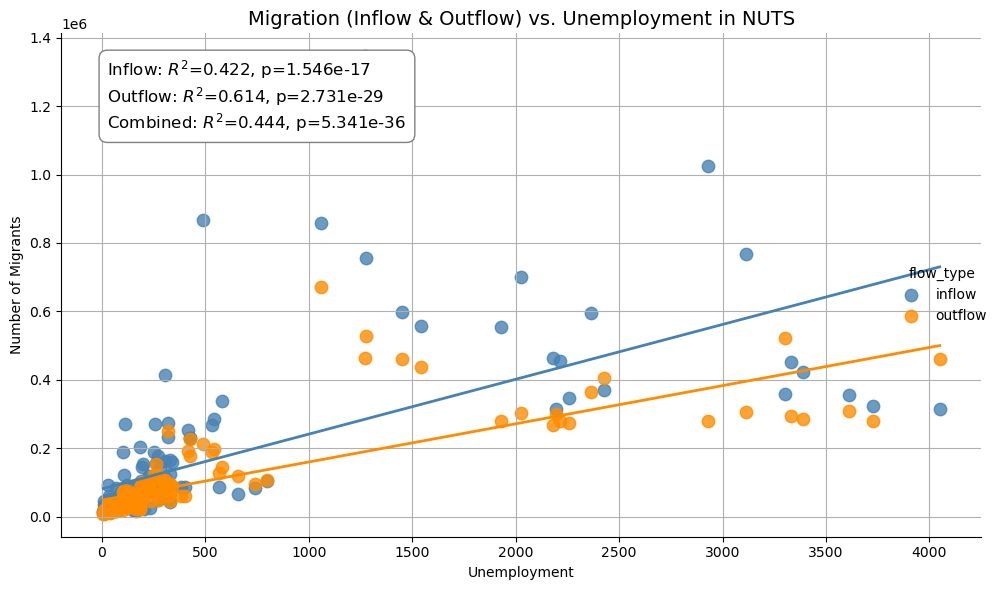

In [12]:
# def plot_nuts_migration_vs_unemployment(merged_NUTS_df):
#     """Scatterplot with regression lines: Migration (inflow/outflow) vs Unemployment rate."""
    
#     plot_data = merged_NUTS_df.dropna(subset=['unemployment', 'inflow', 'outflow'])

#     plot_long = pd.melt(
#         plot_data,
#         id_vars=['geo', 'year', 'unemployment'],
#         value_vars=['inflow', 'outflow'],
#         var_name='flow_type',
#         value_name='num_migrants'
#     )

#     # Regression stats
#     def get_stats(sub_df):
#         slope, intercept, r_value, p_value, std_err = linregress(sub_df['unemployment'], sub_df['num_migrants'])
#         return r_value**2, p_value

#     inflow_df = plot_long[plot_long['flow_type'] == 'inflow']
#     outflow_df = plot_long[plot_long['flow_type'] == 'outflow']

#     r2_in, p_in = get_stats(inflow_df)
#     r2_out, p_out = get_stats(outflow_df)
#     r2_both, p_both = get_stats(plot_long)

#     stats_text = (
#         f'Inflow: $R^2$={r2_in:.3f}, p={p_in:.3e}\n'
#         f'Outflow: $R^2$={r2_out:.3f}, p={p_out:.3e}\n'
#         f'Combined: $R^2$={r2_both:.3f}, p={p_both:.3e}'
#     )

#     # Plot with regression lines
#     g = sns.lmplot(
#         data=plot_long,
#         x='unemployment',
#         y='num_migrants',
#         hue='flow_type',
#         palette={'inflow': 'steelblue', 'outflow': 'darkorange'},
#         height=6,
#         aspect=1.5,
#         scatter_kws={'s': 80, 'alpha': 0.8},
#         line_kws={'linewidth': 2},
#         ci=None
#     )

#     ax = g.ax
#     ax.set_title('Migration (Inflow & Outflow) vs. Unemployment in NUTS', fontsize=14)
#     ax.set_xlabel('Unemployment')
#     ax.set_ylabel('Number of Migrants')

#     ax.text(
#         0.05, 0.95,
#         stats_text,
#         transform=ax.transAxes,
#         fontsize=12,
#         verticalalignment='top',
#         bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5')
#     )

#     plt.tight_layout()
#     # plt.legend(title='Migration Type')
#     plt.grid(True)
#     plt.show()

# plot_nuts_migration_vs_unemployment(merged_NUTS_df)

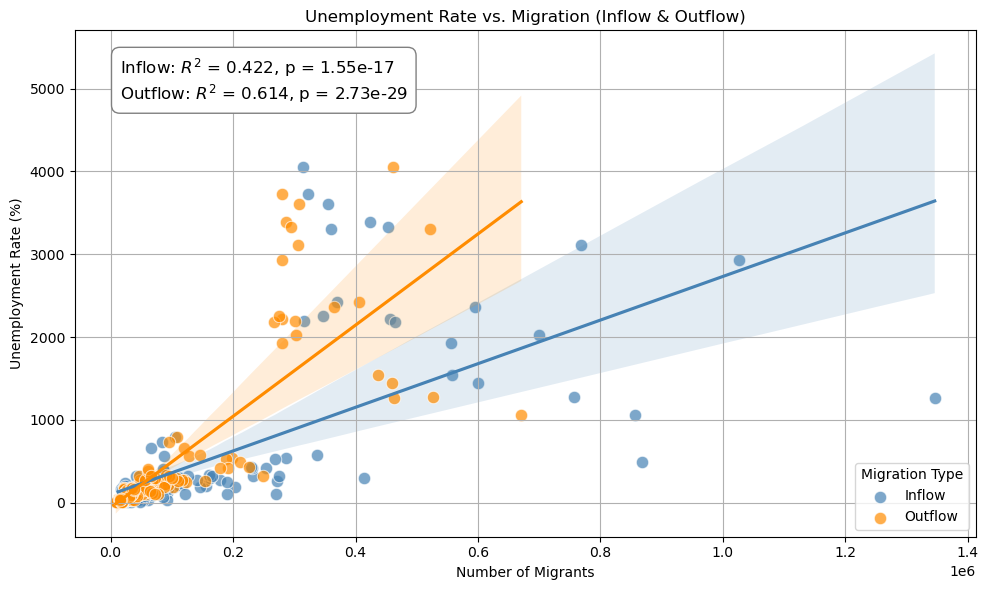

In [20]:
# def plot_nuts_migration_vs_unemployment(merged_NUTS_df):
#     """
#     Scatterplot and regression lines for inflow/outflow vs. unemployment,
#     with R² and p-values shown for each.
#     """
#     # Step 1: Filter out missing values
#     plot_data = merged_NUTS_df.dropna(subset=['unemployment', 'inflow', 'outflow'])

#     # Step 2: Melt the data to long format
#     plot_long = pd.melt(
#         plot_data,
#         id_vars=['geo', 'year', 'unemployment'],
#         value_vars=['inflow', 'outflow'],
#         var_name='flow_type',
#         value_name='num_migrants'
#     )

#     # Step 3: Split into two DataFrames for plotting
#     inflow_df = plot_long[plot_long['flow_type'] == 'inflow']
#     outflow_df = plot_long[plot_long['flow_type'] == 'outflow']

#     # Step 4: Start plotting
#     plt.figure(figsize=(10, 6))

#     # Plot inflow points and regression line
#     sns.scatterplot(data=inflow_df, x='num_migrants', y='unemployment',
#                     color='steelblue', label='Inflow', alpha=0.7, s=80)
#     sns.regplot(data=inflow_df, x='num_migrants', y='unemployment',
#                 scatter=False, color='steelblue')

#     # Plot outflow points and regression line
#     sns.scatterplot(data=outflow_df, x='num_migrants', y='unemployment',
#                     color='darkorange', label='Outflow', alpha=0.7, s=80)
#     sns.regplot(data=outflow_df, x='num_migrants', y='unemployment',
#                 scatter=False, color='darkorange')

#     # Step 5: Calculate regression stats
#     def get_stats(df):
#         slope, intercept, r_value, p_value, std_err = linregress(df['num_migrants'], df['unemployment'])
#         return r_value ** 2, p_value

#     r2_in, p_in = get_stats(inflow_df)
#     r2_out, p_out = get_stats(outflow_df)

#     # Step 6: Add stats box
#     stats_text = (
#         f"Inflow: $R^2$ = {r2_in:.3f}, p = {p_in:.2e}\n"
#         f"Outflow: $R^2$ = {r2_out:.3f}, p = {p_out:.2e}"
#     )

#     plt.text(
#         0.05, 0.95,
#         stats_text,
#         transform=plt.gca().transAxes,
#         fontsize=12,
#         verticalalignment='top',
#         bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5')
#     )

#     # Step 7: Final formatting
#     plt.title('Unemployment Rate vs. Migration (Inflow & Outflow)')
#     plt.xlabel('Number of Migrants')
#     plt.ylabel('Unemployment Rate (%)')
#     plt.grid(True)
#     plt.legend(title='Migration Type')
#     plt.tight_layout()
#     plt.show()
# plot_nuts_migration_vs_unemployment(merged_NUTS_df)


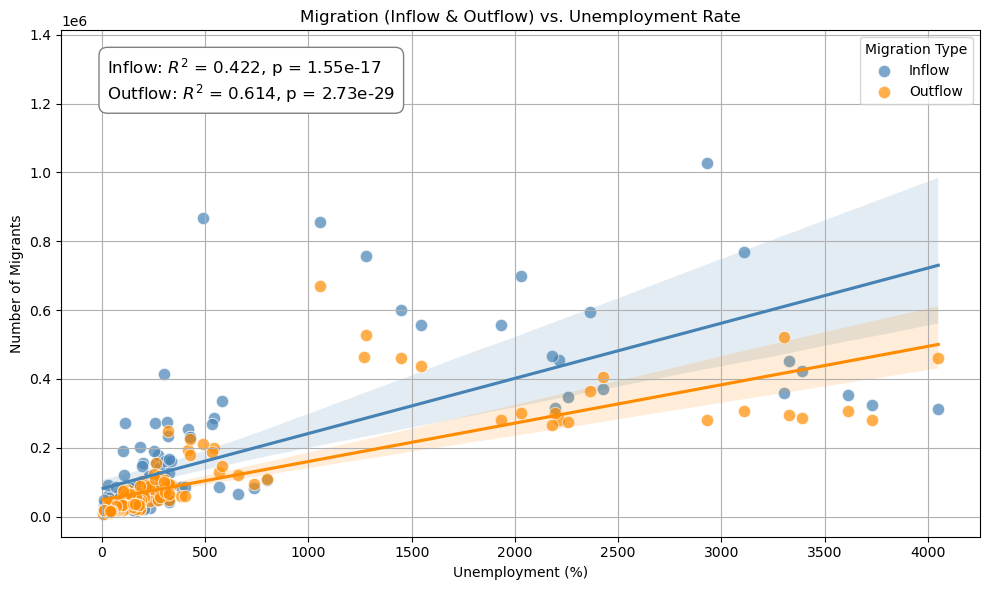

In [9]:
def plot_nuts_migration_vs_unemployment(merged_NUTS_df):
    """
    Scatterplot and regression lines for migration (inflow/outflow) vs. unemployment,
    with R² and p-values shown for each.
    """
    # Step 1: Filter out missing values
    plot_data = merged_NUTS_df.dropna(subset=['unemployment', 'inflow', 'outflow'])

    # Step 2: Melt the data to long format
    plot_long = pd.melt(
        plot_data,
        id_vars=['geo', 'year', 'unemployment'],
        value_vars=['inflow', 'outflow'],
        var_name='flow_type',
        value_name='num_migrants'
    )

    # Step 3: Split into two DataFrames for plotting
    inflow_df = plot_long[plot_long['flow_type'] == 'inflow']
    outflow_df = plot_long[plot_long['flow_type'] == 'outflow']

    # Step 4: Start plotting
    plt.figure(figsize=(10, 6))

    # Plot inflow points and regression line
    sns.scatterplot(data=inflow_df, x='unemployment', y='num_migrants',
                    color='steelblue', label='Inflow', alpha=0.7, s=80)
    sns.regplot(data=inflow_df, x='unemployment', y='num_migrants',
                scatter=False, color='steelblue')

    # Plot outflow points and regression line
    sns.scatterplot(data=outflow_df, x='unemployment', y='num_migrants',
                    color='darkorange', label='Outflow', alpha=0.7, s=80)
    sns.regplot(data=outflow_df, x='unemployment', y='num_migrants',
                scatter=False, color='darkorange')

    # Step 5: Calculate regression stats (X = unemployment, Y = migrants)
    def get_stats(df):
        slope, intercept, r_value, p_value, std_err = linregress(df['unemployment'], df['num_migrants'])
        return r_value ** 2, p_value

    r2_in, p_in = get_stats(inflow_df)
    r2_out, p_out = get_stats(outflow_df)

    # Step 6: Add stats box
    stats_text = (
        f"Inflow: $R^2$ = {r2_in:.3f}, p = {p_in:.2e}\n"
        f"Outflow: $R^2$ = {r2_out:.3f}, p = {p_out:.2e}"
    )

    plt.text(
        0.05, 0.95,
        stats_text,
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5')
    )

    # Step 7: Final formatting
    plt.title('Migration (Inflow & Outflow) vs. Unemployment')
    plt.xlabel('Unemployment (%)')
    plt.ylabel('Number of Migrants')
    plt.grid(True)
    plt.legend(title='Migration Type')
    plt.tight_layout()
    plt.show()
plot_nuts_migration_vs_unemployment(merged_NUTS_df)


In [11]:
# Melt the data to long format
plot_data = merged_NUTS_df.dropna(subset=['unemployment', 'inflow', 'outflow'])
plot_long = pd.melt(
    plot_data,
    id_vars=['geo', 'year', 'unemployment'],
    value_vars=['inflow', 'outflow'],
    var_name='flow_type',
    value_name='num_migrants'
)

# Define a helper to get R² and p
def get_stats(df):
    result = linregress(df['num_migrants'], df['unemployment'])
    return result.rvalue ** 2, result.pvalue

# Calculate
r2_in, p_in = get_stats(plot_long[plot_long['flow_type'] == 'inflow'])
r2_out, p_out = get_stats(plot_long[plot_long['flow_type'] == 'outflow'])
r2_both, p_both = get_stats(plot_long)

# Print the results
print(f"Inflow   → R²: {r2_in:.3f}, p-value: {p_in:.3e}")
print(f"Outflow  → R²: {r2_out:.3f}, p-value: {p_out:.3e}")
print(f"Combined → R²: {r2_both:.3f}, p-value: {p_both:.3e}")


Inflow   → R²: 0.422, p-value: 1.546e-17
Outflow  → R²: 0.614, p-value: 2.731e-29
Combined → R²: 0.444, p-value: 5.341e-36


📈 What the stats mean:  
✅ Inflow → R²: 0.422, p = 1.546e-17  
- About 42.2% of the variation in unemployment rates can be explained by inflow migration numbers.  
- p-value is very small, meaning the relationship is statistically significant.  

✅ Outflow → R²: 0.614, p = 2.731e-29  
- Outflow explains 61.4% of unemployment variation — a stronger relationship than inflow.  
- The p-value is even smaller → highly significant.  
This could suggest emigration (people leaving) is more strongly tied to labor market conditions.

🔄 Combined → R²: 0.444, p = 5.341e-36
When combining both inflow and outflow into one variable, R² is slightly higher than inflow alone, but lower than outflow.

That’s expected: combining two trends that may behave differently (and possibly in opposite ways) can dilute individual effects.

## Unemployment Rate Data - todo: add population

In [25]:
def load_filtered_employment_data(filepath):
    # Step 1: Load the raw .tsv file
    raw = pd.read_csv(filepath, delimiter='\t', dtype=str)

    # Step 2: Split metadata column into proper ID columns
    id_cols = ['freq', 'unit', 'citizen', 'sex', 'age', 'geo']
    raw[id_cols] = raw.iloc[:, 0].str.split(',', expand=True)
    raw = raw.drop(columns=raw.columns[0])

    # Step 3: Melt into long format
    tidy = raw.melt(id_vars=id_cols, var_name='year', value_name='value')

    # Step 4: Extract numeric values and flags
    tidy[['numeric_value', 'flag']] = tidy['value'].str.extract(r'([\d.]+|:)\s*([a-z]*)')
    tidy['numeric_value'] = tidy['numeric_value'].replace(':', np.nan).astype(float)
    tidy['year'] = tidy['year'].astype(int)

    # Step 5: Filter the data according to your criteria
    result = tidy[
        (tidy['citizen'] == 'TOTAL') &
        (tidy['sex'] == 'T') &
        (tidy['age'] == 'Y20-64') &
        (tidy['year'].between(2019, 2022)) &
        (tidy['geo'].str.match(r'^[A-Z]{2}$')) &
        (tidy['geo'] != '')
    ][['geo', 'year', 'numeric_value']]

    return result

unemployment_rate = load_filtered_employment_data(DATA_DIR / "Migration/unemployment/estat_lfst_r_lfur2gan.tsv")
unemployment_rate

,geo,year,numeric_value


### NUTS Merge

In [13]:
# Step 4: Merge migration and employment
def merge_migration_employment_NUTS(migration_df, employment_df):
    return pd.merge(
        migration_df, employment_df,
        on=['geo', 'year'],
        how='inner'
    ).rename(columns={'numeric_value': 'unemployment_rate'})

unemployment_Migration_NUTS = merge_migration_employment_NUTS(migration_flow, unemployment_rate)
unemployment_Migration_NUTS

,geo,year,outflow,inflow,unemployment_rate
0,AT,2019,75894,103587,4.3
1,AT,2020,78738,76056,5.3
2,AT,2021,66872,82422,6.0
3,AT,2022,61468,154988,4.5
4,BA,2019,60246,26869,NaN
...,...,...,...,...,...
139,TR,2022,521337,359872,10.4
140,UK,2019,670647,856989,3.4
141,UK,2020,629902,658333,NaN
142,UK,2021,470148,845371,NaN


### Population Merge

In [14]:
def load_population_data(filepath):
    """
    Load and clean Eurostat population data (.tsv format),
    returning a tidy DataFrame with ['geo', 'year', 'population'].
    """
    import pandas as pd

    # Step 1: Read raw file
    pop_raw = pd.read_csv(filepath, delimiter='\t', dtype=str)

    # Step 2: Parse and rename first column
    original_id_col = pop_raw.columns[0]
    meta_cols = original_id_col.split(',')
    meta_cols[-1] = 'geo'  # Replace geo\\TIME_PERIOD with geo

    pop_raw[meta_cols] = pop_raw[original_id_col].str.split(',', expand=True)
    pop_raw = pop_raw.drop(columns=original_id_col)

    # Step 3: Melt to long format
    pop_long = pop_raw.melt(id_vars=meta_cols, var_name='year', value_name='population')

    # Step 4: Clean values
    pop_long['population'] = pop_long['population'].str.extract(r'([\d.]+)').astype(float)
    pop_long['year'] = pop_long['year'].astype(int)

    # Step 5: Filter to total population
    pop_filtered = pop_long[
        (pop_long['age'] == 'TOTAL') &
        (pop_long['sex'] == 'T') &
        (pop_long['year'].between(2019, 2022)) &
        (pop_long['geo'].str.match(r'^[A-Z]{2}$')) &
        (pop_long['geo'] != '') &
        (pop_long['unit'].isin(['NR', 'NUMBER']))  # Some files use 'NR', some 'NUMBER'
    ][['geo', 'year', 'population']].copy()

    return pop_filtered
    
# Load population data
pop_df = load_population_data(DATA_DIR / 'Migration/unemployment/estat_demo_r_pjanaggr3.tsv')
# pop_df

unemployment_Migration_Pop_NUTS = unemployment_Migration_NUTS.merge(pop_df, on=['geo', 'year'], how='left')
unemployment_Migration_Pop_NUTS

,geo,year,outflow,inflow,unemployment_rate,population
0,AT,2019,75894,103587,4.3,8858775.0
1,AT,2020,78738,76056,5.3,8901064.0
2,AT,2021,66872,82422,6.0,8932664.0
3,AT,2022,61468,154988,4.5,8978929.0
4,BA,2019,60246,26869,NaN,NaN
...,...,...,...,...,...,...
139,TR,2022,521337,359872,10.4,84680273.0
140,UK,2019,670647,856989,3.4,66647112.0
141,UK,2020,629902,658333,NaN,NaN
142,UK,2021,470148,845371,NaN,NaN


### Plot

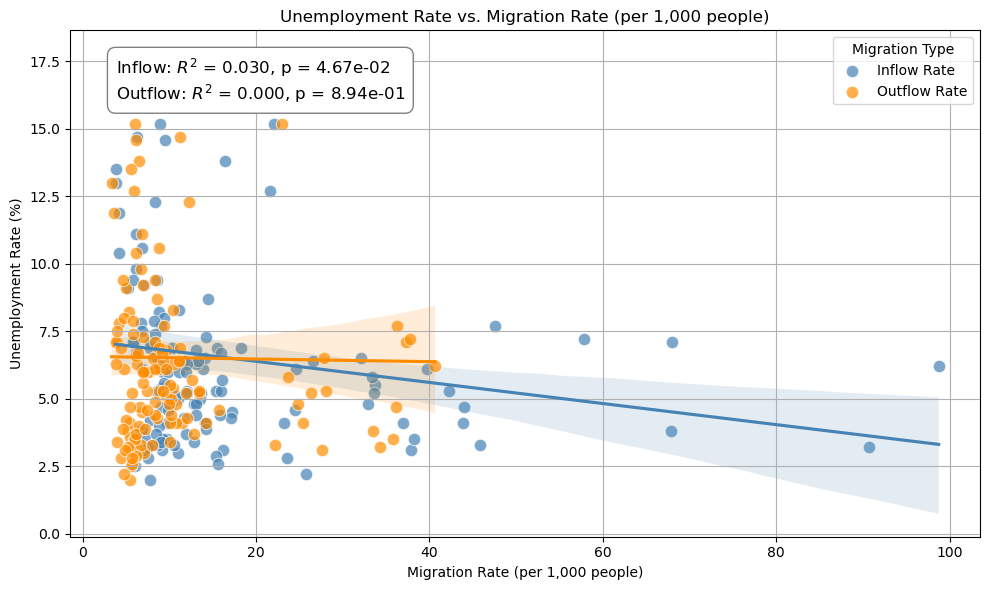

In [15]:
def plot_migration_vs_unemployment(df):
    """
    Scatter plot with regression lines for unemployment rate vs. migration inflow/outflow per 1,000 people.
    Includes separate regression lines and R²/p-value annotations for inflow and outflow.
    """
    # Drop rows with missing data
    df = df.dropna(subset=['unemployment_rate', 'inflow', 'outflow', 'population']).copy()

    # Normalize migration values per 1,000 people
    df['inflow_rate'] = df['inflow'] / df['population'] * 1000
    df['outflow_rate'] = df['outflow'] / df['population'] * 1000

    # Melt into long format
    plot_long = pd.melt(
        df,
        id_vars=['geo', 'year', 'unemployment_rate'],
        value_vars=['inflow_rate', 'outflow_rate'],
        var_name='flow_type',
        value_name='migration_rate'
    )

    # Split for separate regression plotting
    inflow_df = plot_long[plot_long['flow_type'] == 'inflow_rate']
    outflow_df = plot_long[plot_long['flow_type'] == 'outflow_rate']

    # Begin plot
    plt.figure(figsize=(10, 6))

    # Inflow points and regression
    sns.scatterplot(data=inflow_df, x='migration_rate', y='unemployment_rate',
                    color='steelblue', label='Inflow Rate', s=80, alpha=0.7)
    sns.regplot(data=inflow_df, x='migration_rate', y='unemployment_rate',
                scatter=False, color='steelblue')

    # Outflow points and regression
    sns.scatterplot(data=outflow_df, x='migration_rate', y='unemployment_rate',
                    color='darkorange', label='Outflow Rate', s=80, alpha=0.7)
    sns.regplot(data=outflow_df, x='migration_rate', y='unemployment_rate',
                scatter=False, color='darkorange')

    # Compute stats
    def get_stats(sub_df):
        slope, intercept, r_value, p_value, std_err = linregress(sub_df['migration_rate'], sub_df['unemployment_rate'])
        return r_value ** 2, p_value

    r2_in, p_in = get_stats(inflow_df)
    r2_out, p_out = get_stats(outflow_df)

    # Annotation
    stats_text = (
        f"Inflow: $R^2$ = {r2_in:.3f}, p = {p_in:.2e}\n"
        f"Outflow: $R^2$ = {r2_out:.3f}, p = {p_out:.2e}"
    )

    plt.text(
        0.05, 0.95,
        stats_text,
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5')
    )

    # Final formatting
    plt.title("Unemployment Rate vs. Migration Rate (per 1,000 people)")
    plt.xlabel("Migration Rate (per 1,000 people)")
    plt.ylabel("Unemployment Rate (%)")
    plt.grid(True)
    plt.legend(title="Migration Type")
    plt.tight_layout()
    plt.show()

plot_migration_vs_unemployment(unemployment_Migration_Pop_NUTS)


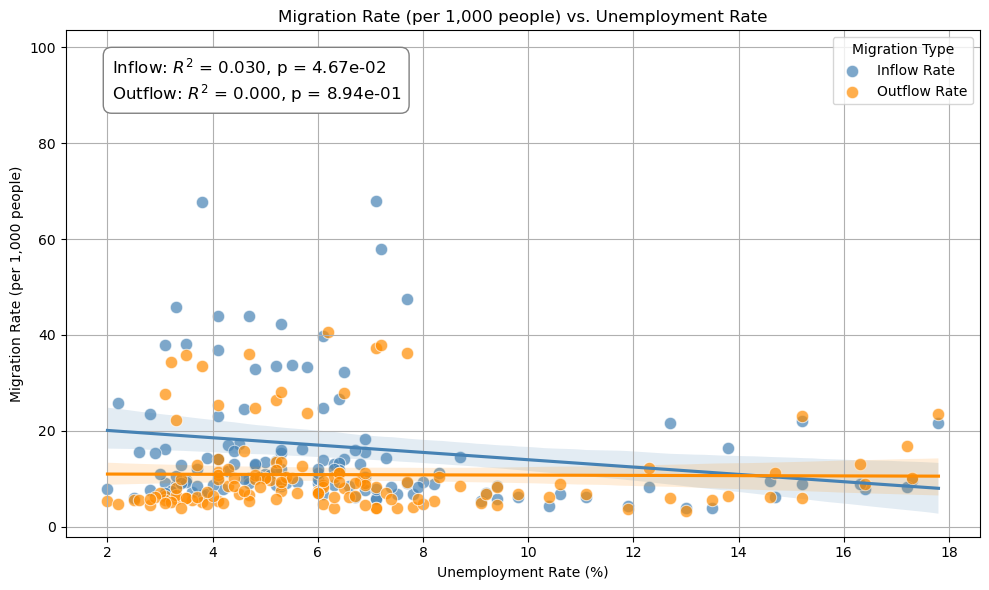

In [16]:
def plot_migration_vs_unemployment(df):
    """
    Scatter plot with regression lines for migration inflow/outflow per 1,000 people vs. unemployment rate.
    Includes separate regression lines and R²/p-value annotations for inflow and outflow.
    """
    # Drop rows with missing data
    df = df.dropna(subset=['unemployment_rate', 'inflow', 'outflow', 'population']).copy()

    # Normalize migration values per 1,000 people
    df['inflow_rate'] = df['inflow'] / df['population'] * 1000
    df['outflow_rate'] = df['outflow'] / df['population'] * 1000

    # Melt into long format
    plot_long = pd.melt(
        df,
        id_vars=['geo', 'year', 'unemployment_rate'],
        value_vars=['inflow_rate', 'outflow_rate'],
        var_name='flow_type',
        value_name='migration_rate'
    )

    # Split for separate regression plotting
    inflow_df = plot_long[plot_long['flow_type'] == 'inflow_rate']
    outflow_df = plot_long[plot_long['flow_type'] == 'outflow_rate']

    # Begin plot
    plt.figure(figsize=(10, 6))

    # Inflow points and regression line
    sns.scatterplot(data=inflow_df, x='unemployment_rate', y='migration_rate',
                    color='steelblue', label='Inflow Rate', s=80, alpha=0.7)
    sns.regplot(data=inflow_df, x='unemployment_rate', y='migration_rate',
                scatter=False, color='steelblue')

    # Outflow points and regression line
    sns.scatterplot(data=outflow_df, x='unemployment_rate', y='migration_rate',
                    color='darkorange', label='Outflow Rate', s=80, alpha=0.7)
    sns.regplot(data=outflow_df, x='unemployment_rate', y='migration_rate',
                scatter=False, color='darkorange')

    # Compute regression stats (X = unemployment, Y = migration rate)
    def get_stats(sub_df):
        slope, intercept, r_value, p_value, std_err = linregress(sub_df['unemployment_rate'], sub_df['migration_rate'])
        return r_value ** 2, p_value

    r2_in, p_in = get_stats(inflow_df)
    r2_out, p_out = get_stats(outflow_df)

    # Annotation box
    stats_text = (
        f"Inflow: $R^2$ = {r2_in:.3f}, p = {p_in:.2e}\n"
        f"Outflow: $R^2$ = {r2_out:.3f}, p = {p_out:.2e}"
    )

    plt.text(
        0.05, 0.95,
        stats_text,
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5')
    )

    # Final formatting
    plt.title("Migration Rate (per 1,000 people) vs. Unemployment Rate")
    plt.xlabel("Unemployment Rate (%)")
    plt.ylabel("Migration Rate (per 1,000 people)")
    plt.grid(True)
    plt.legend(title="Migration Type")
    plt.tight_layout()
    plt.show()

plot_migration_vs_unemployment(unemployment_Migration_Pop_NUTS)

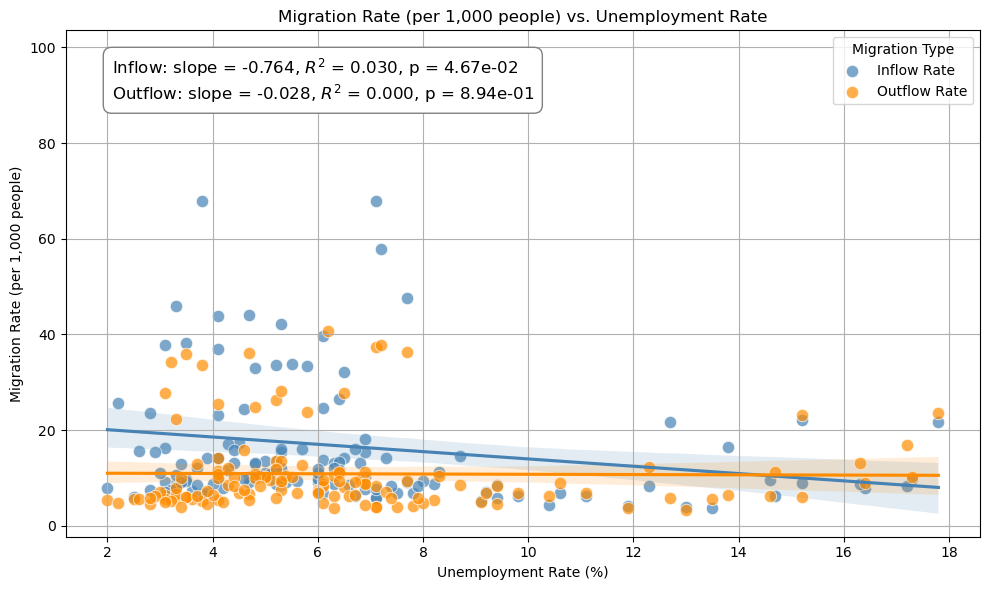

In [19]:
def plot_migration_vs_unemployment(df):
    """
    Scatter plot with regression lines for migration inflow/outflow per 1,000 people vs. unemployment rate.
    Includes slope, R², and p-value annotations for inflow and outflow.
    """
    from scipy.stats import linregress
    import seaborn as sns
    import matplotlib.pyplot as plt
    import pandas as pd

    # Drop rows with missing data
    df = df.dropna(subset=['unemployment_rate', 'inflow', 'outflow', 'population']).copy()

    # Normalize migration values per 1,000 people
    df['inflow_rate'] = df['inflow'] / df['population'] * 1000
    df['outflow_rate'] = df['outflow'] / df['population'] * 1000

    # Melt into long format
    plot_long = pd.melt(
        df,
        id_vars=['geo', 'year', 'unemployment_rate'],
        value_vars=['inflow_rate', 'outflow_rate'],
        var_name='flow_type',
        value_name='migration_rate'
    )

    # Split data
    inflow_df = plot_long[plot_long['flow_type'] == 'inflow_rate']
    outflow_df = plot_long[plot_long['flow_type'] == 'outflow_rate']

    # Start plot
    plt.figure(figsize=(10, 6))

    # Scatter + regression: inflow
    sns.scatterplot(data=inflow_df, x='unemployment_rate', y='migration_rate',
                    color='steelblue', label='Inflow Rate', s=80, alpha=0.7)
    sns.regplot(data=inflow_df, x='unemployment_rate', y='migration_rate',
                scatter=False, color='steelblue')

    # Scatter + regression: outflow
    sns.scatterplot(data=outflow_df, x='unemployment_rate', y='migration_rate',
                    color='darkorange', label='Outflow Rate', s=80, alpha=0.7)
    sns.regplot(data=outflow_df, x='unemployment_rate', y='migration_rate',
                scatter=False, color='darkorange')

    # Regression stats with slope
    def get_stats(sub_df):
        slope, intercept, r_value, p_value, std_err = linregress(
            sub_df['unemployment_rate'],
            sub_df['migration_rate']
        )
        return slope, r_value**2, p_value

    slope_in, r2_in, p_in = get_stats(inflow_df)
    slope_out, r2_out, p_out = get_stats(outflow_df)

    # Stats box text
    stats_text = (
        f"Inflow: slope = {slope_in:.3f}, $R^2$ = {r2_in:.3f}, p = {p_in:.2e}\n"
        f"Outflow: slope = {slope_out:.3f}, $R^2$ = {r2_out:.3f}, p = {p_out:.2e}"
    )

    # Annotate
    plt.text(
        0.05, 0.95,
        stats_text,
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5')
    )

    # Final formatting
    plt.title("Migration Rate (per 1,000 people) vs. Unemployment Rate")
    plt.xlabel("Unemployment Rate (%)")
    plt.ylabel("Migration Rate (per 1,000 people)")
    plt.grid(True)
    plt.legend(title="Migration Type")
    plt.tight_layout()
    plt.show()
plot_migration_vs_unemployment(unemployment_Migration_Pop_NUTS)

# International - not correct: rate and number

## Unemployment Rate Data
ILO estimate source: https://data.worldbank.org/indicator/SL.UEM.TOTL.ZS 

In [21]:
def load_and_clean_unemployment(filepath, exclude_regions=True):
    """Load unemployment CSV and clean/filter for 2019-2022."""
    years = ['2019', '2020', '2021', '2022']
    keep_cols = ['Country Name', 'Country Code'] + years

    df = pd.read_csv(filepath)
    df_clean = df[keep_cols].copy()
    df_clean = df_clean.dropna(subset=years, how='all')

    if exclude_regions:
        # Remove aggregates/regions by keywords
        df_clean = df_clean[~df_clean['Country Name'].str.contains('Africa|World|income|states', case=False, na=False)]

    # Melt wide to long format
    df_long = df_clean.melt(
        id_vars=['Country Name', 'Country Code'],
        var_name='year',
        value_name='unemployment_rate'
    )
    df_long['year'] = df_long['year'].astype(int)
    df_long['unemployment_rate'] = pd.to_numeric(df_long['unemployment_rate'], errors='coerce')
    df_long = df_long.dropna(subset=['unemployment_rate']).reset_index(drop=True)
    return df_long

unemployment_filepath = DATA_DIR/f"Migration/unemployment/API_SL.UEM.TOTL.ZS_DS2_en_csv_v2_340963.csv"
employment_data_global = load_and_clean_unemployment(unemployment_filepath)
employment_data_global

,Country Name,Country Code,year,unemployment_rate
0,Afghanistan,AFG,2019,11.185
1,Angola,AGO,2019,16.497
2,Albania,ALB,2019,11.466
3,United Arab Emirates,ARE,2019,2.331
4,Argentina,ARG,2019,9.843
...,...,...,...,...
830,Vanuatu,VUT,2022,5.143
831,Samoa,WSM,2022,5.048
832,"Yemen, Rep.",YEM,2022,17.363
833,Zambia,ZMB,2022,5.995


### Global Merge and Plot

In [22]:
def merge_migration_unemployment(migration_flow, df_long, df_all_country):
    """Merge migration flow and unemployment data via country codes."""
    # Map alpha-2 (migration geo) to alpha-3 (unemployment code)
    code_map = df_all_country[['alpha-2', 'alpha-3']].dropna()
    code_map = code_map.rename(columns={'alpha-2': 'geo', 'alpha-3': 'Country Code'})

    # Merge migration with alpha-3 codes
    migration_with_alpha3 = pd.merge(
        migration_flow,
        code_map,
        on='geo',
        how='left'
    )

    # Merge with unemployment data
    final_merged = pd.merge(
        migration_with_alpha3,
        df_long,
        on=['Country Code', 'year'],
        how='left'
    )

    # Optional reorder columns
    final_merged = final_merged[['geo', 'Country Code', 'year', 'inflow', 'outflow', 'unemployment_rate']]
    return final_merged

df_all_country = pd.read_csv(DATA_DIR/"all.csv")
df_all_country = df_all_country[['name', 'alpha-2', 'alpha-3', 'region', 'sub-region']]

global_merged = merge_migration_unemployment(migration_flow, employment_data_global, df_all_country)
global_merged

,geo,Country Code,year,inflow,outflow,unemployment_rate
0,AD,AND,2019,8390,7301,NaN
1,AD,AND,2020,7908,7414,NaN
2,AD,AND,2021,6923,7446,NaN
3,AD,AND,2022,9685,7142,NaN
4,AE,ARE,2019,1248145,769808,2.331
...,...,...,...,...,...,...
715,ZM,ZMB,2022,27207,27844,5.995
716,ZW,ZWE,2019,39165,71874,7.373
717,ZW,ZWE,2020,38031,53204,8.621
718,ZW,ZWE,2021,43564,51055,9.540


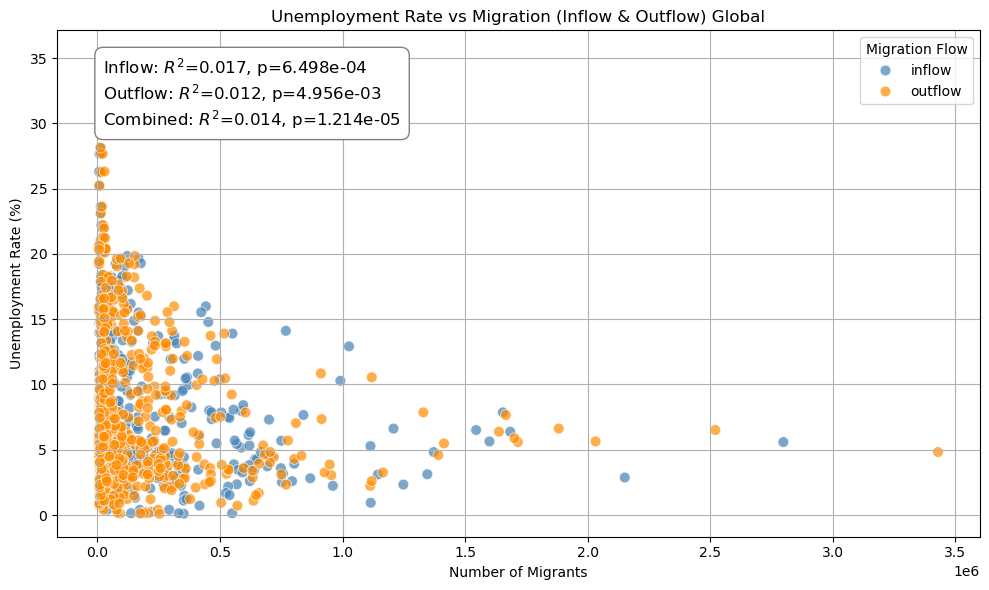

In [23]:
def plot_migration_vs_unemployment(final_merged):
    """Scatterplot inflow and outflow vs unemployment rate with R² and p-values."""
    plot_df = final_merged.dropna(subset=['unemployment_rate', 'inflow', 'outflow'])

    plot_long = pd.melt(
        plot_df,
        id_vars=['geo', 'year', 'unemployment_rate'],
        value_vars=['inflow', 'outflow'],
        var_name='flow_type',
        value_name='num_migrants'
    )
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=plot_long,
        x='num_migrants',
        y='unemployment_rate',
        hue='flow_type',
        palette={'inflow': 'steelblue', 'outflow': 'darkorange'},
        alpha=0.7,
        s=60
    )
    
    # Calculate regressions separately
    def get_stats(sub_df):
        slope, intercept, r_value, p_value, std_err = linregress(sub_df['num_migrants'], sub_df['unemployment_rate'])
        return r_value**2, p_value

    inflow_df = plot_long[plot_long['flow_type'] == 'inflow']
    outflow_df = plot_long[plot_long['flow_type'] == 'outflow']

    r2_in, p_in = get_stats(inflow_df)
    r2_out, p_out = get_stats(outflow_df)

    # Combined (both inflow and outflow together)
    r2_both, p_both = get_stats(plot_long)

    # Add annotation text in the plot
    stats_text = (
        f'Inflow: $R^2$={r2_in:.3f}, p={p_in:.3e}\n'
        f'Outflow: $R^2$={r2_out:.3f}, p={p_out:.3e}\n'
        f'Combined: $R^2$={r2_both:.3f}, p={p_both:.3e}'
    )

    plt.text(
        0.05, 0.95,
        stats_text,
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5')
    )
    
    plt.title('Unemployment Rate vs Migration (Inflow & Outflow) Global')
    plt.xlabel('Number of Migrants')
    plt.ylabel('Unemployment Rate (%)')
    plt.legend(title='Migration Flow')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_migration_vs_unemployment(global_merged)

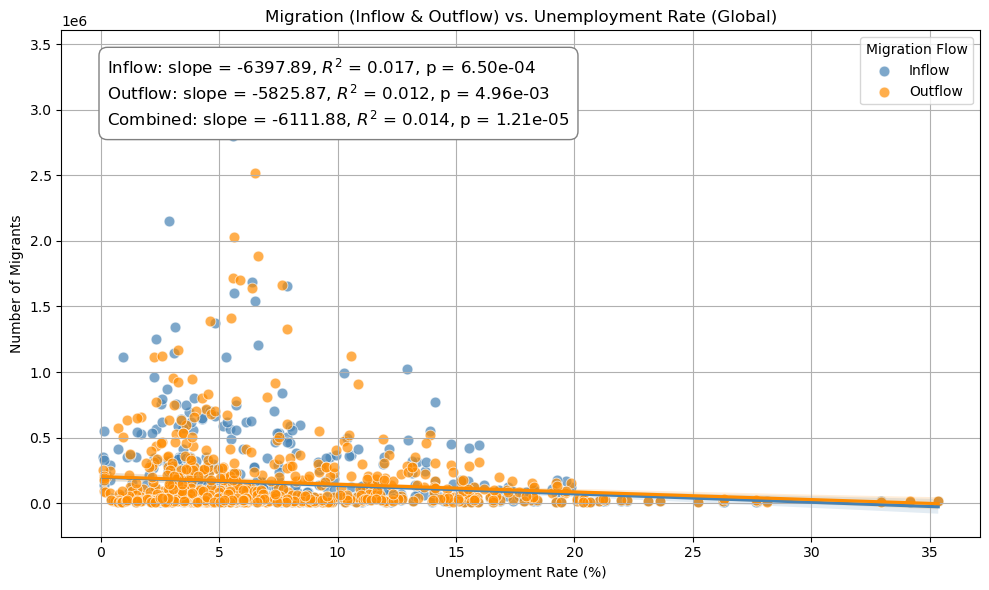

In [24]:
def plot_migration_vs_unemployment(final_merged):
    """Scatterplot: Migration (inflow/outflow) vs. unemployment rate with regression lines, slopes, R², and p-values."""
    
    # Drop missing data
    plot_df = final_merged.dropna(subset=['unemployment_rate', 'inflow', 'outflow'])

    # Reshape to long format
    plot_long = pd.melt(
        plot_df,
        id_vars=['geo', 'year', 'unemployment_rate'],
        value_vars=['inflow', 'outflow'],
        var_name='flow_type',
        value_name='num_migrants'
    )

    # Split for regression
    inflow_df = plot_long[plot_long['flow_type'] == 'inflow']
    outflow_df = plot_long[plot_long['flow_type'] == 'outflow']

    # Create plot
    plt.figure(figsize=(10, 6))

    # Inflow
    sns.scatterplot(data=inflow_df, x='unemployment_rate', y='num_migrants',
                    color='steelblue', label='Inflow', s=60, alpha=0.7)
    sns.regplot(data=inflow_df, x='unemployment_rate', y='num_migrants',
                scatter=False, color='steelblue', label=None)

    # Outflow
    sns.scatterplot(data=outflow_df, x='unemployment_rate', y='num_migrants',
                    color='darkorange', label='Outflow', s=60, alpha=0.7)
    sns.regplot(data=outflow_df, x='unemployment_rate', y='num_migrants',
                scatter=False, color='darkorange', label=None)

    # Regression stats with slope
    def get_stats(sub_df):
        slope, intercept, r_value, p_value, std_err = linregress(
            sub_df['unemployment_rate'], sub_df['num_migrants']
        )
        return slope, r_value**2, p_value

    slope_in, r2_in, p_in = get_stats(inflow_df)
    slope_out, r2_out, p_out = get_stats(outflow_df)
    slope_both, r2_both, p_both = get_stats(plot_long)

    # Annotation text
    stats_text = (
        f"Inflow: slope = {slope_in:.2f}, $R^2$ = {r2_in:.3f}, p = {p_in:.2e}\n"
        f"Outflow: slope = {slope_out:.2f}, $R^2$ = {r2_out:.3f}, p = {p_out:.2e}\n"
        f"Combined: slope = {slope_both:.2f}, $R^2$ = {r2_both:.3f}, p = {p_both:.2e}"
    )

    # Annotate
    plt.text(
        0.05, 0.95,
        stats_text,
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5')
    )

    # Final formatting
    plt.title('Migration (Inflow & Outflow) vs. Unemployment Rate (Global)')
    plt.xlabel('Unemployment Rate (%)')
    plt.ylabel('Number of Migrants')
    plt.legend(title='Migration Flow')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_migration_vs_unemployment(global_merged)